In [3]:
# imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib


In [4]:
# Loading the dataset 
df = pd.read_csv("Terry_Stops_20251225.csv")
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Occurred Date
0,56 and Above,-1,20190000057245,532414,Arrest,NaN,8606,1965,Female,White,...,ASLT - WITH OR W/O WPNS (NO SHOOTINGS),"ASSAULTS, OTHER",911,TRAINING - FIELD TRAINING SQUAD,N,N,West,M,M3,2019-02-15T13:15:00
1,1 - 17,-1,20170000317010,301638,Arrest,NaN,7773,1978,Male,White,...,OBS - FIGHT - IP - PHYSICAL (NO WEAPONS),"ASSAULTS, OTHER",911,NORTH PCT 3RD W - B/N RELIEF,N,N,North,L,L3,2017-08-27T03:18:00
2,36 - 45,7727706299,20250000063255,63109655222,Field Contact,-,8974,1997,Female,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,NORTH PCT 2ND W - BOY (JOHN) - PLATOON 1,N,N,North,U,U2,2025-03-08T17:58:00
3,46 - 55,7729078044,20230000235837,51923259552,Field Contact,-,4494,1961,Male,White,...,DISTURBANCE,MISCHIEF OR NUISANCE - GENERAL,911,CRG - SQUAD 81D,N,Y,Southwest,W,W1,2023-08-16T20:31:00
4,46 - 55,7746702884,20210000151070,25601408632,Arrest,-,8696,1996,Male,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 3RD W - B/N RELIEF,Y,N,North,N,N2,2021-06-18T00:48:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65879,26 - 35,-1,20160000005450,225436,Field Contact,NaN,7660,1970,Female,White,...,-,-,-,NORTH PCT 2ND WATCH - NORTH BEATS,N,N,-,-,-,2016-12-31T13:13:00
65880,46 - 55,8299806915,20190000248310,8604595320,Arrest,-,8388,1986,Male,White,...,OBS - BURG - IP/JO - COMM BURG (INCLUDES SCHOOLS),BURGLARY - NON RESIDENTIAL/COMMERCIAL,911,WEST PCT 1ST W - DAVID - PLATOON 1,Y,N,West,Q,Q1,2019-07-07T12:28:00
65881,18 - 25,50973730927,20250000301885,66730612060,Field Contact,-,9034,1998,Male,Two or More Races,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,NARCOTICS - OTHER,ONVIEW,EAST PCT 3RD W - GEORGE - PLATOON 2,N,N,West,M,M2,2025-10-15T12:25:00
65882,26 - 35,7736599492,20250000266790,66041476925,Arrest,Blunt Object/Striking Implement,8521,1993,Male,Two or More Races,...,FIGHT - CRITICAL WITH WEAPONS,"ASSAULTS - HARASSMENT, THREATS",911,SOUTH PCT 2ND W - ROBERT - PLATOON 2,Y,Y,South,S,S3,2025-09-12T16:58:00


In [5]:
# checking for missing values
df.isnull().sum()

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 566
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
Occurred Date                   0
dtype: int64

In [6]:
# standardizing the column names
df = df.copy()
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')


In [7]:
df.columns = (df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('/', '_'))


In [8]:
# checking for duplicates
df.duplicated().sum()

0

In [9]:
# dropping duplicates
df = df.drop_duplicates()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65884 entries, 0 to 65883
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   subject_age_group         65884 non-null  object
 1   subject_id                65884 non-null  int64 
 2   go___sc_num               65884 non-null  int64 
 3   terry_stop_id             65884 non-null  int64 
 4   stop_resolution           65884 non-null  object
 5   weapon_type               33319 non-null  object
 6   officer_id                65884 non-null  object
 7   officer_yob               65884 non-null  int64 
 8   officer_gender            65884 non-null  object
 9   officer_race              65884 non-null  object
 10  subject_perceived_race    65884 non-null  object
 11  subject_perceived_gender  65884 non-null  object
 12  reported_date             65884 non-null  object
 13  initial_call_type         65884 non-null  object
 14  final_call_type       

In [11]:
# Fixing column names
df = df.copy()
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')


In [12]:
# Converting dates to datetime format 
date_cols = ['reported_date', 'occurred_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')


In [13]:
# Handling missing values
df['weapon_type'] = df['weapon_type'].fillna('None')


In [14]:
df['officer_squad'] = df['officer_squad'].fillna(
    df['officer_squad'].mode()[0]
)


In [15]:
# Encoding target variable
df['arrest_flag'] = df['arrest_flag'].map({'Y': 1, 'N': 0})


In [16]:
# train or test split
train_df, test_df = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df['arrest_flag']
)


In [17]:
median_yob = train_df['officer_yob'].median()

train_df['officer_yob'] = train_df['officer_yob'].fillna(median_yob)
test_df['officer_yob'] = test_df['officer_yob'].fillna(median_yob)


In [18]:
# ONE-HOT ENCODING CATEGORICAL VARIABLES
from sklearn.preprocessing import OneHotEncoder
import numpy as np

cat_cols = [
    'subject_age_group',
    'subject_perceived_race',
    'subject_perceived_gender',
    'officer_gender',
    'precinct'
]

encoder = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
)

encoder.fit(train_df[cat_cols])

X_train_cat = encoder.transform(train_df[cat_cols])
X_test_cat = encoder.transform(test_df[cat_cols])

# Add numeric features
num_cols = ['officer_yob']

X_train = np.hstack((X_train_cat, train_df[num_cols].values))
X_test = np.hstack((X_test_cat, test_df[num_cols].values))

y_train = train_df['arrest_flag']
y_test = test_df['arrest_flag']


In [19]:
# ONE HOT ENCODING
categorical_cols = [col for col in train_df.columns if train_df[col].dtype == 'object']
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65884 entries, 0 to 65883
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   subject_age_group         65884 non-null  object        
 1   subject_id                65884 non-null  int64         
 2   go___sc_num               65884 non-null  int64         
 3   terry_stop_id             65884 non-null  int64         
 4   stop_resolution           65884 non-null  object        
 5   weapon_type               65884 non-null  object        
 6   officer_id                65884 non-null  object        
 7   officer_yob               65884 non-null  int64         
 8   officer_gender            65884 non-null  object        
 9   officer_race              65884 non-null  object        
 10  subject_perceived_race    65884 non-null  object        
 11  subject_perceived_gender  65884 non-null  object        
 12  reported_date     

In [21]:
# checking for missing values
df.isnull().sum()

subject_age_group           0
subject_id                  0
go___sc_num                 0
terry_stop_id               0
stop_resolution             0
weapon_type                 0
officer_id                  0
officer_yob                 0
officer_gender              0
officer_race                0
subject_perceived_race      0
subject_perceived_gender    0
reported_date               0
initial_call_type           0
final_call_type             0
call_type                   0
officer_squad               0
arrest_flag                 0
frisk_flag                  0
precinct                    0
sector                      0
beat                        0
occurred_date               0
dtype: int64

# Data Visualizations

Text(0, 0.5, 'Count')

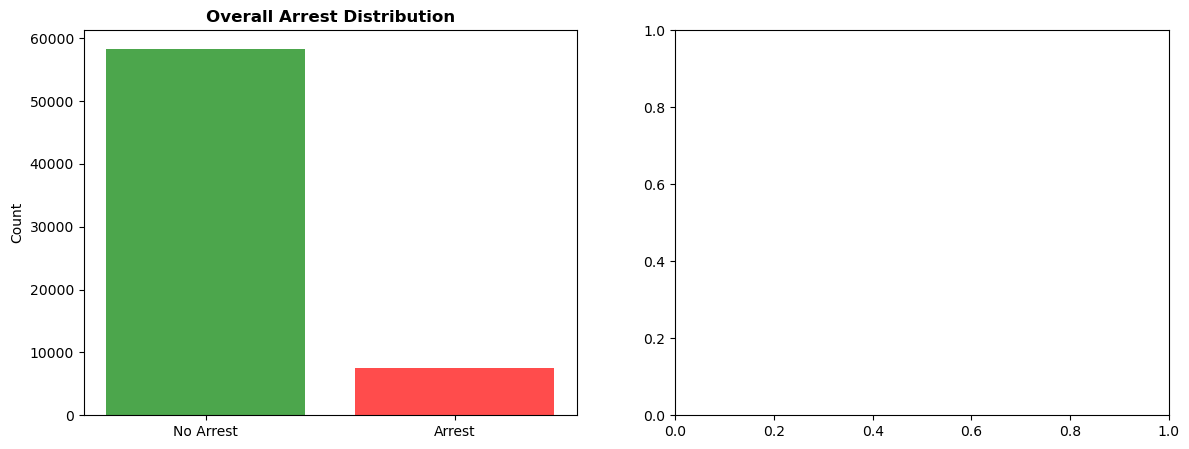

In [22]:
# Arrest Flag Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Overall distribution
arrest_counts = df['arrest_flag'].value_counts()
axes[0].bar(['No Arrest', 'Arrest'], [arrest_counts.get(0, 0), arrest_counts.get(1, 0)], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Overall Arrest Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')

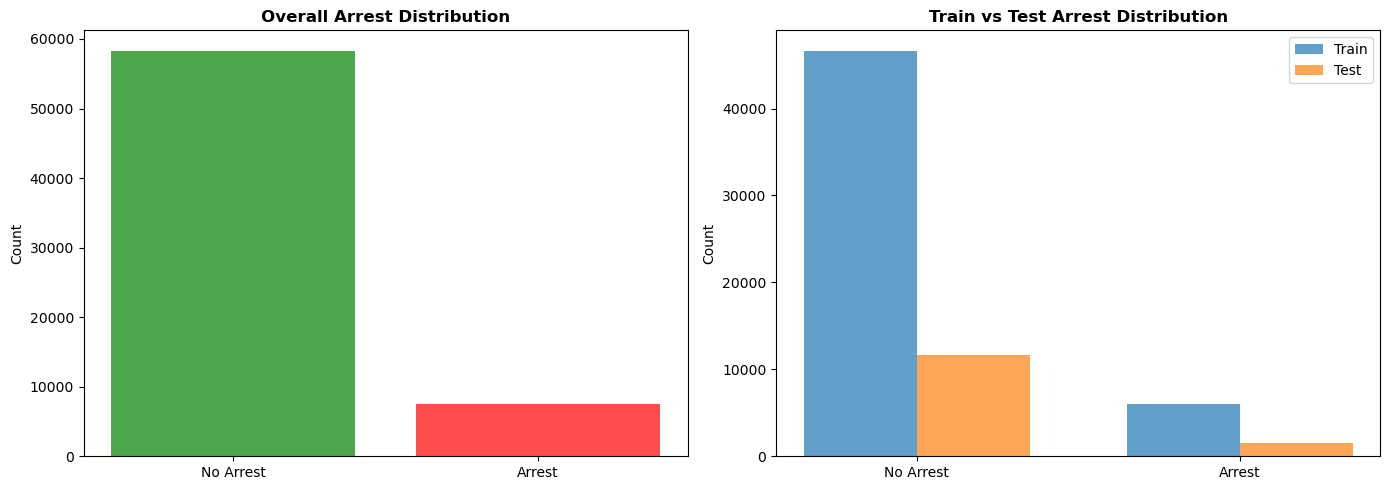

In [23]:
# Arrest Flag Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
arrest_counts = df['arrest_flag'].value_counts()
axes[0].bar(['No Arrest', 'Arrest'], [arrest_counts.get(0, 0), arrest_counts.get(1, 0)], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Overall Arrest Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')

# Train vs Test distribution
train_arrests = train_df['arrest_flag'].value_counts()
test_arrests = test_df['arrest_flag'].value_counts()

x = np.arange(2)
width = 0.35
axes[1].bar(x - width/2, [train_arrests.get(0, 0), train_arrests.get(1, 0)], width, label='Train', alpha=0.7)
axes[1].bar(x + width/2, [test_arrests.get(0, 0), test_arrests.get(1, 0)], width, label='Test', alpha=0.7)
axes[1].set_title('Train vs Test Arrest Distribution', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['No Arrest', 'Arrest'])
axes[1].legend()

plt.tight_layout()
plt.show()


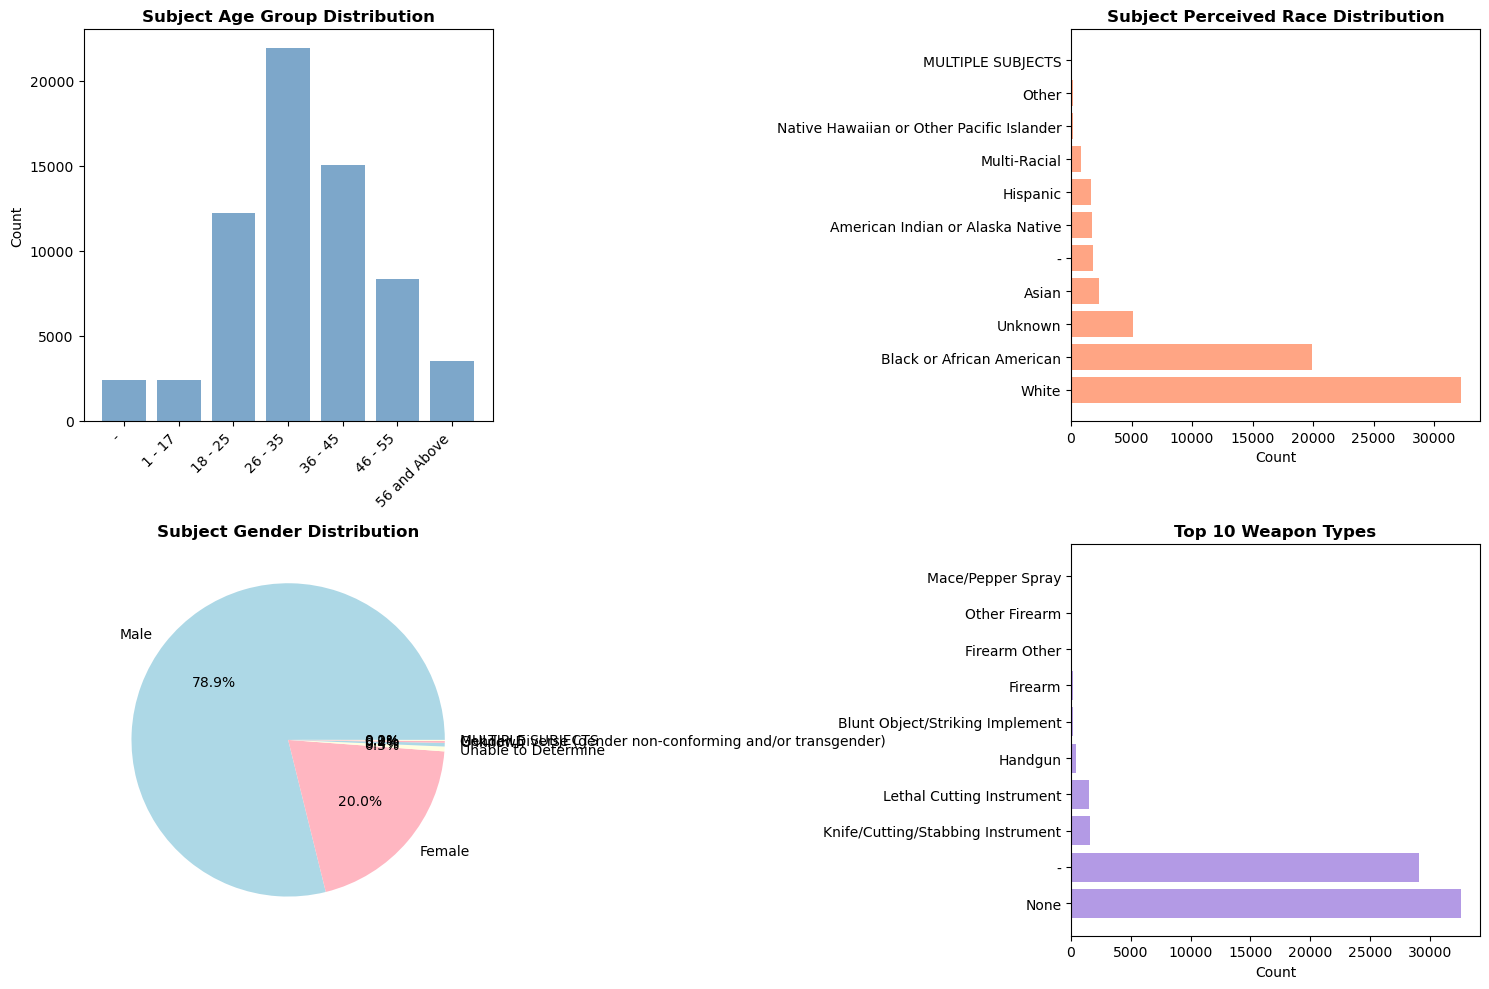

In [24]:
# Subject Demographics Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age Group Distribution
if 'subject_age_group' in df.columns:
    age_group = df['subject_age_group'].value_counts().sort_index()
    axes[0, 0].bar(range(len(age_group)), age_group.values, color='steelblue', alpha=0.7)
    axes[0, 0].set_xticks(range(len(age_group)))
    axes[0, 0].set_xticklabels(age_group.index, rotation=45, ha='right')
    axes[0, 0].set_title('Subject Age Group Distribution', fontweight='bold')
    axes[0, 0].set_ylabel('Count')

# Race Distribution
if 'subject_perceived_race' in df.columns:
    race = df['subject_perceived_race'].value_counts()
    axes[0, 1].barh(range(len(race)), race.values, color='coral', alpha=0.7)
    axes[0, 1].set_yticks(range(len(race)))
    axes[0, 1].set_yticklabels(race.index)
    axes[0, 1].set_title('Subject Perceived Race Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Count')

# Gender Distribution
if 'subject_perceived_gender' in df.columns:
    gender = df['subject_perceived_gender'].value_counts()
    axes[1, 0].pie(gender.values, labels=gender.index, autopct='%1.1f%%', colors=['lightblue', 'lightpink', 'lightyellow'])
    axes[1, 0].set_title('Subject Gender Distribution', fontweight='bold')

# Weapon Type Distribution (Top 10)
if 'weapon_type' in df.columns:
    weapon = df['weapon_type'].value_counts().head(10)
    axes[1, 1].barh(range(len(weapon)), weapon.values, color='mediumpurple', alpha=0.7)
    axes[1, 1].set_yticks(range(len(weapon)))
    axes[1, 1].set_yticklabels(weapon.index)
    axes[1, 1].set_title('Top 10 Weapon Types', fontweight='bold')
    axes[1, 1].set_xlabel('Count')

plt.tight_layout()
plt.show()


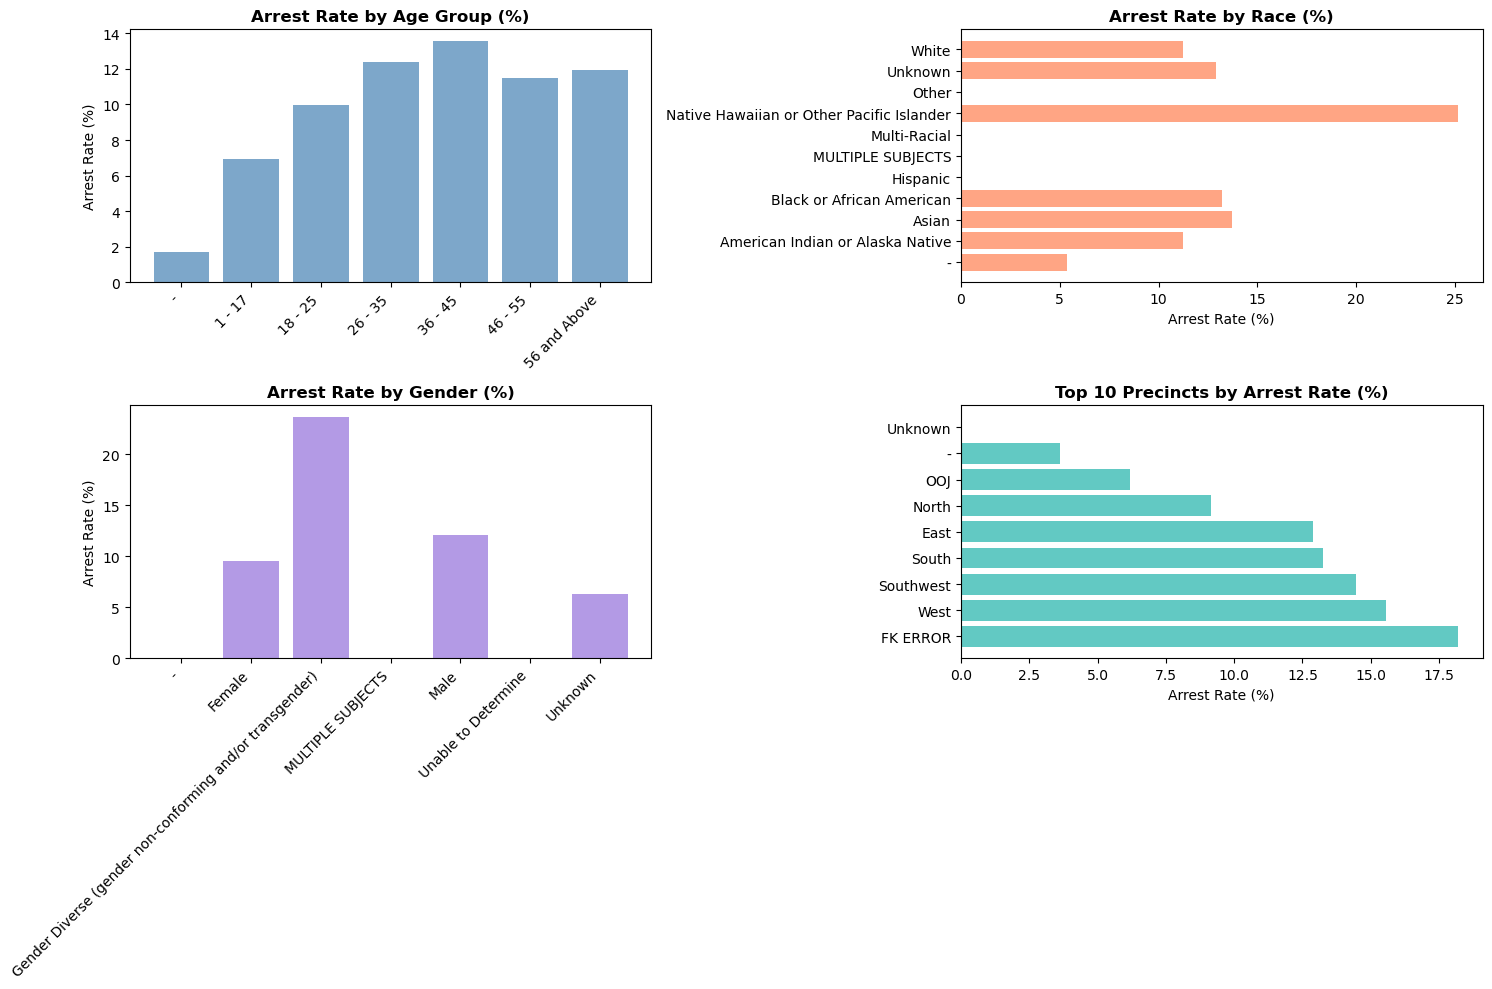

In [25]:
# Arrest Rate by Demographics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Arrest Rate by Age Group
if 'subject_age_group' in df.columns:
    arrest_by_age = df.groupby('subject_age_group')['arrest_flag'].apply(lambda x: (x==1).sum() / len(x) * 100)
    axes[0, 0].bar(range(len(arrest_by_age)), arrest_by_age.values, color='steelblue', alpha=0.7)
    axes[0, 0].set_xticks(range(len(arrest_by_age)))
    axes[0, 0].set_xticklabels(arrest_by_age.index, rotation=45, ha='right')
    axes[0, 0].set_title('Arrest Rate by Age Group (%)', fontweight='bold')
    axes[0, 0].set_ylabel('Arrest Rate (%)')

# Arrest Rate by Race
if 'subject_perceived_race' in df.columns:
    arrest_by_race = df.groupby('subject_perceived_race')['arrest_flag'].apply(lambda x: (x==1).sum() / len(x) * 100)
    axes[0, 1].barh(range(len(arrest_by_race)), arrest_by_race.values, color='coral', alpha=0.7)
    axes[0, 1].set_yticks(range(len(arrest_by_race)))
    axes[0, 1].set_yticklabels(arrest_by_race.index)
    axes[0, 1].set_title('Arrest Rate by Race (%)', fontweight='bold')
    axes[0, 1].set_xlabel('Arrest Rate (%)')

# Arrest Rate by Gender
if 'subject_perceived_gender' in df.columns:
    arrest_by_gender = df.groupby('subject_perceived_gender')['arrest_flag'].apply(lambda x: (x==1).sum() / len(x) * 100)
    axes[1, 0].bar(range(len(arrest_by_gender)), arrest_by_gender.values, color='mediumpurple', alpha=0.7)
    axes[1, 0].set_xticks(range(len(arrest_by_gender)))
    axes[1, 0].set_xticklabels(arrest_by_gender.index, rotation=45, ha='right')
    axes[1, 0].set_title('Arrest Rate by Gender (%)', fontweight='bold')
    axes[1, 0].set_ylabel('Arrest Rate (%)')

# Arrest Rate by Precinct
if 'precinct' in df.columns:
    arrest_by_precinct = df.groupby('precinct')['arrest_flag'].apply(lambda x: (x==1).sum() / len(x) * 100).sort_values(ascending=False).head(10)
    axes[1, 1].barh(range(len(arrest_by_precinct)), arrest_by_precinct.values, color='lightseagreen', alpha=0.7)
    axes[1, 1].set_yticks(range(len(arrest_by_precinct)))
    axes[1, 1].set_yticklabels(arrest_by_precinct.index)
    axes[1, 1].set_title('Top 10 Precincts by Arrest Rate (%)', fontweight='bold')
    axes[1, 1].set_xlabel('Arrest Rate (%)')

plt.tight_layout()
plt.show()


# Model Training and Evaluation

In [26]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Model Training Complete!")
print(f"Training Accuracy: {rf_model.score(X_train, y_train):.4f}")
print(f"Testing Accuracy: {rf_model.score(X_test, y_test):.4f}")


Model Training Complete!
Training Accuracy: 0.8990
Testing Accuracy: 0.8745


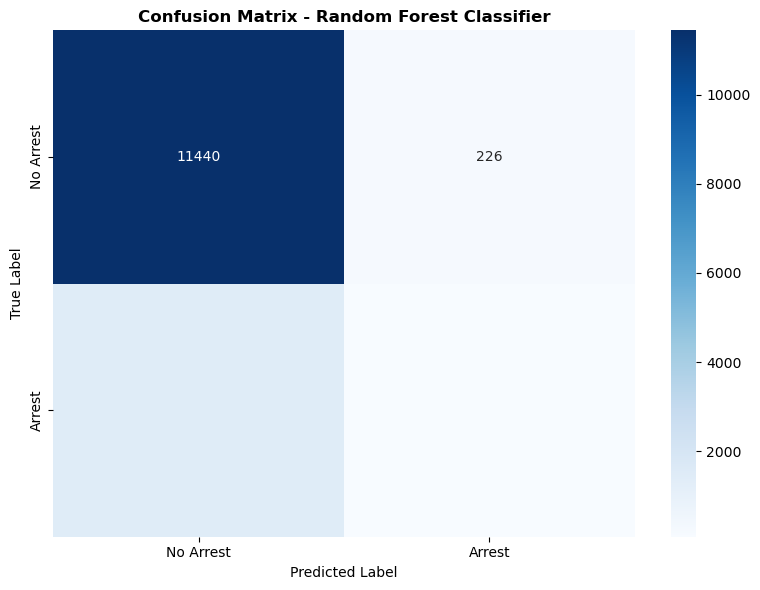


Classification Report:
              precision    recall  f1-score   support

   No Arrest       0.89      0.98      0.93     11666
      Arrest       0.27      0.05      0.09      1511

    accuracy                           0.87     13177
   macro avg       0.58      0.52      0.51     13177
weighted avg       0.82      0.87      0.84     13177



In [27]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            xticklabels=['No Arrest', 'Arrest'],
            yticklabels=['No Arrest', 'Arrest'])
ax.set_title('Confusion Matrix - Random Forest Classifier', fontweight='bold', fontsize=12)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Arrest', 'Arrest']))


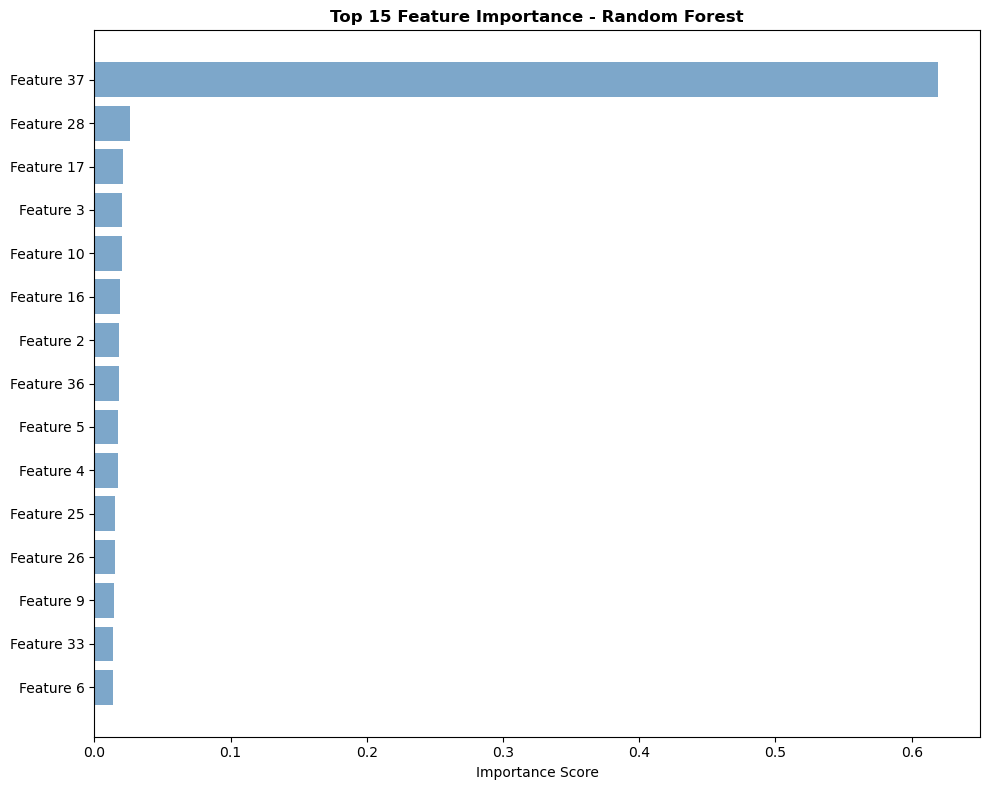

In [28]:
# Feature Importance Visualization
feature_importance = pd.DataFrame({
    'feature': range(len(rf_model.feature_importances_)),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(feature_importance)), feature_importance['importance'].values, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(feature_importance)))
ax.set_yticklabels([f"Feature {i}" for i in feature_importance['feature'].values])
ax.set_title('Top 15 Feature Importance - Random Forest', fontweight='bold', fontsize=12)
ax.set_xlabel('Importance Score')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


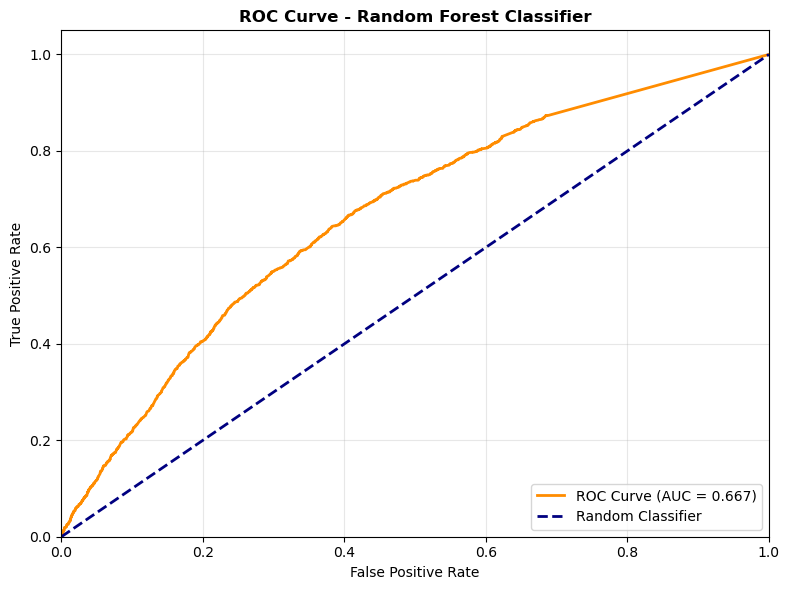

In [29]:
# ROC Curve and AUC Score
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Random Forest Classifier', fontweight='bold', fontsize=12)
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Additional Machine Learning Models

In [30]:
# Import additional models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
import time

# Dictionary to store all models and their results
models = {
    'Random Forest': rf_model,
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5)
}

In [31]:
# Train all models and store predictions
results = {}

print("Training additional models...\n")

for model_name, model in models.items():
    if model_name == 'Random Forest':
        # Already trained
        y_pred_model = y_pred
        y_pred_proba_model = y_pred_proba
    else:
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred_model = model.predict(X_test)
        y_pred_proba_model = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
        training_time = time.time() - start_time

Training additional models...



In [ ]:
# Import additional models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
import time

# Dictionary to store all models and their results
models = {
    'Random Forest': rf_model,
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5)
}

# Train all models and store predictions
results = {}

print("Training additional models...\n")

for model_name, model in models.items():
    if model_name == 'Random Forest':
        # Already trained
        y_pred_model = y_pred
        y_pred_proba_model = y_pred_proba
    else:
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred_model = model.predict(X_test)
        y_pred_proba_model = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
        training_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_model)
    precision = (y_pred_model[y_pred_model == 1] == y_test[y_pred_model == 1]).sum() / (y_pred_model == 1).sum() if (y_pred_model == 1).sum() > 0 else 0
    f1 = f1_score(y_test, y_pred_model)
    
    results[model_name] = {
        'model': model,
        'predictions': y_pred_model,
        'probabilities': y_pred_proba_model,
        'accuracy': accuracy,
        'f1_score': f1
    }
    
    print(f"{model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print()


Training additional models...

Random Forest:
  Accuracy: 0.8745
  F1 Score: 0.0912

Logistic Regression:
  Accuracy: 0.8853
  F1 Score: 0.0000

Gradient Boosting:
  Accuracy: 0.8853
  F1 Score: 0.0000



In [ ]:
# Model Comparison Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy Comparison
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
f1_scores = [results[m]['f1_score'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0, 0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='steelblue')
axes[0, 0].bar(x + width/2, f1_scores, width, label='F1 Score', alpha=0.8, color='coral')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Confusion Matrices for all models
cm_data = []
for model_name in ['Random Forest', 'Logistic Regression', 'Gradient Boosting']:
    if model_name in results:
        cm = confusion_matrix(y_test, results[model_name]['predictions'])
        cm_data.append((model_name, cm))

# Show first 3 confusion matrices
if len(cm_data) >= 1:
    cm1 = cm_data[0][1]
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 1],
                xticklabels=['No Arrest', 'Arrest'],
                yticklabels=['No Arrest', 'Arrest'])
    axes[0, 1].set_title(f'Confusion Matrix - {cm_data[0][0]}', fontweight='bold')
    axes[0, 1].set_ylabel('True Label')
    axes[0, 1].set_xlabel('Predicted Label')

# 3. ROC Curves for all models
for model_name in model_names:
    if model_name in results:
        y_pred_proba_model = results[model_name]['probabilities']
        try:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba_model)
            roc_auc = auc(fpr, tpr)
            axes[1, 0].plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
        except:
            pass

axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves - All Models', fontweight='bold', fontsize=12)
axes[1, 0].legend(loc="lower right", fontsize=9)
axes[1, 0].grid(alpha=0.3)

# 4. Model Ranking
model_ranking = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
model_names_ranked = [m[0] for m in model_ranking]
accuracies_ranked = [m[1]['accuracy'] for m in model_ranking]

colors = ['gold', 'silver', '#CD7F32'] + ['steelblue'] * (len(model_names_ranked) - 3)
axes[1, 1].barh(range(len(model_names_ranked)), accuracies_ranked, color=colors, alpha=0.8)
axes[1, 1].set_yticks(range(len(model_names_ranked)))
axes[1, 1].set_yticklabels(model_names_ranked)
axes[1, 1].set_xlabel('Accuracy Score')
axes[1, 1].set_title('Model Ranking by Accuracy', fontweight='bold', fontsize=12)
axes[1, 1].set_xlim([0, 1])

# Add value labels
for i, v in enumerate(accuracies_ranked):
    axes[1, 1].text(v + 0.02, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()


In [ ]:
# Precision-Recall Curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Precision-Recall curves for all models
for model_name in ['Random Forest', 'Logistic Regression', 'Gradient Boosting']:
    if model_name in results:
        y_pred_proba_model = results[model_name]['probabilities']
        try:
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_model)
            f1 = f1_score(y_test, results[model_name]['predictions'])
            axes[0].plot(recall, precision, lw=2, label=f'{model_name} (F1 = {f1:.3f})')
        except:
            pass

axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curves', fontweight='bold', fontsize=12)
axes[0].legend(loc="best")
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Feature Importance for Random Forest (already calculated)
feature_importance = pd.DataFrame({
    'feature': range(len(rf_model.feature_importances_)),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[1].barh(range(len(feature_importance)), feature_importance['importance'].values, color='mediumpurple', alpha=0.8)
axes[1].set_yticks(range(len(feature_importance)))
axes[1].set_yticklabels([f"Feature {i}" for i in feature_importance['feature'].values])
axes[1].set_title('Top 10 Feature Importance - Random Forest', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Importance Score')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:
# Cross-Model Error Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. False Positive and False Negative Rates
model_names_list = list(results.keys())
fp_rates = []
fn_rates = []
tp_rates = []
tn_rates = []

for model_name in model_names_list:
    cm = confusion_matrix(y_test, results[model_name]['predictions'])
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    
    fp_rates.append(fp / (fp + tn))
    fn_rates.append(fn / (fn + tp))
    tp_rates.append(tp / (tp + fn))
    tn_rates.append(tn / (tn + fp))

x = np.arange(len(model_names_list))
width = 0.2

axes[0, 0].bar(x - width*1.5, tp_rates, width, label='True Positive Rate', alpha=0.8)
axes[0, 0].bar(x - width/2, tn_rates, width, label='True Negative Rate', alpha=0.8)
axes[0, 0].bar(x + width/2, fp_rates, width, label='False Positive Rate', alpha=0.8)
axes[0, 0].bar(x + width*1.5, fn_rates, width, label='False Negative Rate', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Rate')
axes[0, 0].set_title('Confusion Matrix Rates by Model', fontweight='bold', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names_list, rotation=45, ha='right')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Prediction Distribution
for model_name in ['Random Forest', 'Logistic Regression', 'Gradient Boosting']:
    if model_name in results:
        axes[0, 1].hist(results[model_name]['probabilities'], bins=30, alpha=0.6, label=model_name)

axes[0, 1].set_xlabel('Predicted Probability of Arrest')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Probability Distribution - Top 3 Models', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Specificity vs Sensitivity
sensitivities = tp_rates  # True Positive Rate
specificities = tn_rates   # True Negative Rate

axes[1, 0].scatter(specificities, sensitivities, s=200, alpha=0.6)
for i, model_name in enumerate(model_names_list):
    axes[1, 0].annotate(model_name, (specificities[i], sensitivities[i]), 
                       fontsize=9, ha='center', va='bottom')

axes[1, 0].set_xlabel('Specificity (True Negative Rate)')
axes[1, 0].set_ylabel('Sensitivity (True Positive Rate)')
axes[1, 0].set_title('Sensitivity vs Specificity Trade-off', fontweight='bold', fontsize=12)
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(alpha=0.3)

# 4. Accuracy vs F1 Score comparison
accuracies_list = [results[m]['accuracy'] for m in model_names_list]
f1_scores_list = [results[m]['f1_score'] for m in model_names_list]

axes[1, 1].scatter(accuracies_list, f1_scores_list, s=200, alpha=0.6, c=range(len(model_names_list)), cmap='viridis')
for i, model_name in enumerate(model_names_list):
    axes[1, 1].annotate(model_name, (accuracies_list[i], f1_scores_list[i]), 
                       fontsize=9, ha='center', va='bottom')

axes[1, 1].set_xlabel('Accuracy')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('Accuracy vs F1 Score by Model', fontweight='bold', fontsize=12)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Model Comparison Summary Table
from sklearn.metrics import precision_score, recall_score

summary_data = []

for model_name in results.keys():
    y_pred_model = results[model_name]['predictions']
    accuracy = accuracy_score(y_test, y_pred_model)
    precision = precision_score(y_test, y_pred_model, zero_division=0)
    recall = recall_score(y_test, y_pred_model, zero_division=0)
    f1 = f1_score(y_test, y_pred_model)
    
    summary_data.append({
        'Model': model_name,
        'Accuracy': f'{accuracy:.4f}',
        'Precision': f'{precision:.4f}',
        'Recall': f'{recall:.4f}',
        'F1 Score': f'{f1:.4f}'
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)


In [ ]:
# Learning Curves for Random Forest
from sklearn.model_selection import learning_curve

print("Computing learning curves... This may take a moment.")

train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(n_estimators=50, random_state=42),
    X_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score', linewidth=2, markersize=6)
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

ax.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score', linewidth=2, markersize=6)
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Score')
ax.set_title('Learning Curve - Random Forest Classifier', fontweight='bold', fontsize=12)
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Learning curve complete!")
